# Signed Graph Convolutional Network(SGCN)を用いたFraud User Detection

In [1]:
!git branch

* master


In [2]:
import sys
sys.path.append('../models/')
sys.path.append('../utils/')

In [3]:
from sgcn import SignedGCNTrainer, SignedGCNPredictor
from parser_ import parameter_parser
from utils import tab_printer, read_graph, score_printer, save_logs
import easydict
import argparse
import pandas as pd
import numpy as np
import torch
import json
import networkx as nx
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [4]:
data_name = input('データセット：')

データセット：alpha


In [5]:
args = easydict.EasyDict({
        "edge_path": f'../data/input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../data/input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../data/input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../data/tmp/embedding/{data_name}_sgcn_feature.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../data/tmp/weights/{data_name}_sgcn_feature.pkl',
        "inductive_model_path": None, # f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature.json',
        "epochs":300,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32,16],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
        "l1_lambda":0.1,
})

```python
args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": None, # f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":300,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32,16],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
        "l1_lambda":0.1,
})
```

In [6]:
display(pd.io.json.json_normalize(args).T)

,0
class_weights,False
edge_path,../data/input/alpha/alpha_network.csv
embedding_path,../data/tmp/embedding/alpha_sgcn_feature.pkl
epochs,300
eval_freq,1
features_path,../data/input/alpha/alpha_node_feature.csv
general_features,True
hidden_residual,False
inductive_model_path,None
l1_lambda,0.1


## 10-fold cross-validation
- train : validation : test = 6:3:1

In [7]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [8]:
from sklearn.model_selection import StratifiedKFold

In [9]:
kf = StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']
auc_scores = []
regression_weights = []

In [10]:
for i, (train_index, test_index) in enumerate(kf.split(X=nodes_dict['indice'],y=nodes_dict['label'])):
    print("==== Training Phase ====")
    print('{}-th fold'.format(i))
    # training
    train_node_indice = all_indice[train_index]
    train_node_labels = all_labels[train_index]
    print('labels:{}'.format(np.unique(train_node_labels,return_counts=True)))
    tmp_nodes_dict = {}
    tmp_nodes_dict['all_ncount'] = nodes_dict['all_ncount']
    tmp_nodes_dict['indice'] = train_node_indice
    tmp_nodes_dict['label'] = train_node_labels
    trainer = SignedGCNTrainer(args, edges, tmp_nodes_dict)
    trainer.setup_dataset()
    trainer.create_and_train_model()
    
    if args.test_size > 0:
        # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
        # score_printer(trainer.logs)
        display(pd.DataFrame(trainer.logs['performance']))
        save_logs(args, trainer.logs)

    # test
    print("==== Test Phase ====")
    test_node_indice = all_indice[test_index]
    test_node_labels = all_labels[test_index]
    # feature = pd.read_csv(args.embedding_path,index_col='id').values
    feature = pd.read_pickle(args.embedding_path).drop('id',1).values
    test_feature = feature[test_node_indice]
    # weight = pd.read_csv(args.regression_weights_path)
    weight = pd.read_pickle(args.regression_weights_path)
    predictions = np.dot(test_feature,weight.values.T)
    # probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions)).numpy()
    probabilities = torch.sigmoid(torch.from_numpy(predictions)).numpy()
    predict_labels = (probabilities>=0.5).astype(int)
    # auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=probabilities[:,1])
    auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=probabilities)
    auc_scores.append(auc_score)
    cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels)
    regression_weights.append(trainer.model.regression_weights)
    print("{0}-th fold's auc_score:{1}".format(i,auc_score))
    print(cmx)
    print()

Loss:   0%|          | 0/300 [00:00<?, ?it/s]

==== Training Phase ====
0-th fold
labels:(array([-1,  1]), array([ 91, 124]))

Training started.



SGCN (Loss=0.0189): 100%|██████████| 300/300 [03:01<00:00,  1.69it/s]


,0,1,2
0,Epoch,AUC,F1
1,1,0.792683,0
2,2,0.825203,0
3,3,0.842276,0
4,4,0.860976,0
5,5,0.873984,0
6,6,0.887805,0
7,7,0.895935,0
8,8,0.901626,0
9,9,0.904065,0


Loss:   0%|          | 0/300 [00:00<?, ?it/s]

==== Test Phase ====
0-th fold's auc_score:1.0
[[14  0]
 [ 1 10]]

==== Training Phase ====
1-th fold
labels:(array([-1,  1]), array([ 91, 124]))

Training started.



SGCN (Loss=0.0362):  18%|█▊        | 55/300 [00:33<02:27,  1.66it/s]

KeyboardInterrupt: 

In [11]:
np.mean(auc_scores)

1.0

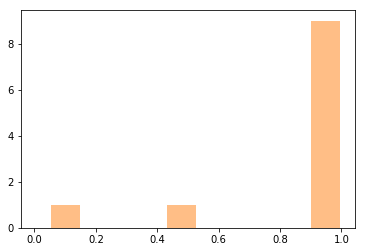

In [12]:
_ = plt.hist(probabilities[test_node_labels==1],alpha=0.5,bins=10)
_ = plt.hist(probabilities[test_node_labels==-1],alpha=0.5,bins=10)
# plt.xlim(0,0.03)

In [ ]:
_ = plt.hist(trainer.model.regression_weights.cpu().detach().numpy()[:,0])

## single-validation

In [ ]:
data_name = input('データセット：')

In [ ]:
args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":300,
        "test_size":0.2,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32, 16, ],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
        "l1_lambda":0.05,
})

In [ ]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [ ]:
np.unique(nodes_dict['label'],return_counts=True)

### Easy task (学習に全て使う)

In [ ]:
trainer = SignedGCNTrainer(args, edges, nodes_dict)
trainer.setup_dataset()
trainer.create_and_train_model()

In [ ]:
if args.test_size > 0:
    # trainer.save_model()
    # score_printer(trainer.logs)
    display(pd.DataFrame(trainer.logs['performance']))
    save_logs(args, trainer.logs)

In [ ]:
# np.save(arr=trainer.used_train_indice, file=f'../output/inductive/{data_name}_train_indice.npy')

# np.save(arr=trainer.used_test_indice, file=f'../output/inductive/{data_name}_test_indice.npy')

## inductive prediction

In [ ]:
data_name = input('データセット：')

In [ ]:
new_args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":300,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32, 16, ],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
        "l1_lambda":0.0,
})

In [ ]:
new_edges, new_nodes_dict = read_graph(new_args)

X = np.array(pd.read_csv(f'../input/{data_name}/{data_name}_node_feature.csv')) # general node features

In [ ]:
training_dataset = input('学習に使ったデータセット：')

In [ ]:
predictor = SignedGCNPredictor(new_args, f'../output/inductive/{training_dataset}_model', X, new_edges,new_nodes_dict)

predictions = predictor.predict()
predict_labels = predictions.argmax(1)

In [ ]:
trained_node_raw = np.load(f'../input/{training_dataset}/{training_dataset}_label_encoder.npy')

newly_added_node_judger = ~np.isin(new_nodes_dict['indice'],trained_node_raw)

In [ ]:
y_true = new_nodes_dict['label'][newly_added_node_judger]
y_score_indice = new_nodes_dict['indice'][newly_added_node_judger]

roc_auc_score(y_true=[1 if i==-1 else 0 for i in y_true],y_score=predictions[y_score_indice])

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix
confusion_matrix([1 if i==-1 else 0 for i in new_nodes_dict['label']],predict_labels[new_nodes_dict['indice']])

In [ ]:
_ = plt.hist(predictions[new_nodes_dict['indice']][y_true==1],alpha=0.5,bins=10)
_ = plt.hist(predictions[new_nodes_dict['indice']][y_true==-1],alpha=0.5,bins=10)

## epinions dataset

In [ ]:
data_name = 'epinions'

In [ ]:
args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',#'../input/{data_name}/user_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',#'../input/{data_name}/user_network.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":150,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32, 16, ],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":True,
})

In [ ]:
display(pd.io.json.json_normalize(args).T)

In [ ]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [ ]:
test_X = np.array(pd.read_csv(args.features_path))

In [ ]:
def subgraph_making(args,edges,nodes_dict,sample_node_num,train_node_indice_original,neighbor_sampling=True):
    original_network_df = pd.read_csv(args.edge_path)
    if neighbor_sampling == True:
        first_neightbors = np.unique(original_network_df.loc[(original_network_df.id1_.isin(train_node_indice_original)) | 
                                                                                                      (original_network_df.id2_.isin(train_node_indice_original)), ['id1_','id2_']].values)
        sampled_node_indice = np.random.choice(first_neightbors,sample_node_num,replace=False)
    else:
        sampled_node_indice = set(np.random.choice(np.arange(nodes_dict['all_ncount']), sample_node_num, replace=False)) | set(train_node_indice_original)

    sub_network_df = \
        original_network_df.loc[(original_network_df.id1_.isin(sampled_node_indice)) & (original_network_df.id2_.isin(sampled_node_indice))]

    original_gt_df = pd.read_csv(args.nodes_path)

    sub_gt_df = \
        original_gt_df.copy().loc[(original_gt_df.node_id.isin(sub_network_df.id1_)) & (original_gt_df.node_id.isin(sub_network_df.id2_))]

    from sklearn.preprocessing import LabelEncoder

    subGraph_map_encoder = LabelEncoder()

    subGraph_map_encoder.fit(list(set(sub_network_df.id1_) | set(sub_network_df.id2_) | set(sub_gt_df.node_id)))

    sub_gt_df['node_id'] = subGraph_map_encoder.transform(sub_gt_df.node_id)

    sub_network_df['id1_'] = subGraph_map_encoder.transform(sub_network_df.id1_)

    sub_network_df['id2_'] = subGraph_map_encoder.transform(sub_network_df.id2_)

    sub_edges = {}

    sub_edges['positive_edges'] = sub_network_df.loc[sub_network_df.weight==1,['id1_','id2_']].values.tolist()

    sub_edges['negative_edges'] = sub_network_df.loc[sub_network_df.weight==-1,['id1_','id2_']].values.tolist()

    sub_edges['ecount'] = len(sub_network_df)

    sub_edges['ncount'] = len(set(sub_network_df['id1_']) | set(sub_network_df['id2_']))

    sub_nodes_dict = {}

    sub_nodes_dict['indice'] = sub_gt_df.node_id.values
    sub_nodes_dict['label'] = sub_gt_df.label.values

    sub_nodes_dict['all_ncount'] = len(set(sub_network_df.id1_) | set(sub_network_df.id2_) | set(sub_gt_df.node_id))

    sub_nodes_dict['subgraph_map_from_original_feature'] = subGraph_map_encoder.classes_    
    return sub_edges, sub_nodes_dict, subGraph_map_encoder

In [ ]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True, random_state=0)
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']

In [ ]:
auc_scores = []
# train : 90 % cross-validation
for i, (train_index, test_index) in enumerate(kf.split(X=nodes_dict['indice'],y=nodes_dict['label'])):
    print("==== Training Phase ====")
    print(f'{i}-th fold')
    # training
    train_node_indice_original = all_indice[train_index] #⬅️これは元々のグラフのnode_indice

    # extract sub-graph
    sub_edges, sub_nodes_dict,subGraph_map_encoder = subgraph_making(args,edges,nodes_dict,10000, train_node_indice_original)
                                                                     # np.random.choice(train_node_indice_original,1000))
    
    train_indice_boolean_judger = np.isin(subGraph_map_encoder.inverse_transform(sub_nodes_dict['indice']),train_node_indice_original)
    train_node_indice = sub_nodes_dict['indice'][train_indice_boolean_judger]
    train_node_labels = sub_nodes_dict['label'][train_indice_boolean_judger]
    print(f'labels:{np.unique(train_node_labels,return_counts=True)}')
    tmp_nodes_dict = {}
    tmp_nodes_dict['all_ncount'] = sub_nodes_dict['all_ncount']
    tmp_nodes_dict['indice'] = train_node_indice
    tmp_nodes_dict['label'] = train_node_labels
    tmp_nodes_dict['subgraph_map_from_original_feature'] = subGraph_map_encoder.classes_
    trainer = SignedGCNTrainer(args, sub_edges, tmp_nodes_dict)
    trainer.setup_dataset()
    trainer.create_and_train_model()
    
    if args.test_size > 0:
        # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
        # score_printer(trainer.logs)
        display(pd.DataFrame(trainer.logs['performance']))
        save_logs(args, trainer.logs)

    # test
    print("==== Test Phase ====")
    test_node_indice = all_indice[test_index]
    test_node_labels = all_labels[test_index]
    predictor = SignedGCNPredictor(args, args.inductive_model_path, test_X, edges,nodes_dict)
    predictions = predictor.predict()
    predict_labels = predictions.argmax(1)
    auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=predictions[:,1][test_node_indice])
    auc_scores.append(auc_score)
    cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels[test_node_indice])
    print(f"{i}-th fold's auc_score:{auc_score}")
    print(cmx)
    print()
    

In [ ]:
np.mean(auc_scores)

## epinions Robustness

In [ ]:
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']

In [ ]:
def robustness_experiments(training_rates_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    all_auc_scores = []
    done_train_rate = []
    training_rates = training_rates_list
    for train_rate in training_rates:
        print(f'train_rate : {train_rate}')
        auc_scores = []
        for i in range(10): 
            train_index, test_index = train_test_split(np.arange(len(nodes_dict['indice'])),
                                                       stratify=nodes_dict['label'],train_size=float(train_rate),shuffle=True)

            print("==== Training Phase ====")
            print(f'{i}-th')
            # training
            train_node_indice_original = all_indice[train_index] #⬅️これは元々のグラフのnode_indice
            # extract sub-graph
            sub_edges, sub_nodes_dict,subGraph_map_encoder = subgraph_making(args,edges,nodes_dict, 20000, 
                                                                             np.random.choice(train_node_indice_original,1000))
            train_indice_boolean_judger = np.isin(subGraph_map_encoder.inverse_transform(sub_nodes_dict['indice']),train_node_indice_original)
            train_node_indice = sub_nodes_dict['indice'][train_indice_boolean_judger]
            train_node_labels = sub_nodes_dict['label'][train_indice_boolean_judger]

            print(f'labels:{np.unique(train_node_labels,return_counts=True)}')
            tmp_nodes_dict = {}
            tmp_nodes_dict['all_ncount'] = sub_nodes_dict['all_ncount']
            tmp_nodes_dict['indice'] = train_node_indice
            tmp_nodes_dict['label'] = train_node_labels
            tmp_nodes_dict['subgraph_map_from_original_feature'] = subGraph_map_encoder.classes_
            trainer = SignedGCNTrainer(args, sub_edges, tmp_nodes_dict)
            trainer.setup_dataset()
            trainer.create_and_train_model()
 
            if args.test_size > 0:
                # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
                # score_printer(trainer.logs)
                display(pd.DataFrame(trainer.logs['performance']))
                save_logs(args, trainer.logs)

            # test
            print("==== Test Phase ====")
            test_node_indice = all_indice[test_index]
            test_node_labels = all_labels[test_index]
            predictor = SignedGCNPredictor(args, args.inductive_model_path, test_X, edges,nodes_dict)
            predictions = predictor.predict()
            predict_labels = predictions.argmax(1)
            auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=predictions[:,1][test_node_indice])
            auc_scores.append(auc_score)
            cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels[test_node_indice])

            print(f"{i}-th fold's auc_score:{auc_score}")
            print(cmx)
            print()
        all_auc_scores.append(np.mean(auc_scores))
        done_train_rate.append(train_rate)
        print(f'rate{train_rate} --> {np.mean(auc_scores)}')
        pd.DataFrame(all_auc_scores,index=done_train_rate).to_csv('tmp_{data_name}.csv'.format(data_name))
    return pd.DataFrame(all_auc_scores, index=training_rates, columns=['average_auc'])

In [ ]:
epi_result_df = robustness_experiments([0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
epi_result_df.to_csv('epinions_robustness.csv')

In [ ]:
epi_result_df.T

# ロバストネスの検証

In [ ]:
data_name = input('データセット：')

In [ ]:
args = easydict.EasyDict({
        "edge_path": f'../input/{data_name}/{data_name}_network.csv',
        "features_path":  f'../input/{data_name}/{data_name}_node_feature.csv',
        "nodes_path": f'../input/{data_name}/{data_name}_gt.csv',
        "embedding_path": f'../tmp/embedding/{data_name}_sgcn_feature05.pkl', # tmp folder for cross-validation
        "regression_weights_path": f'../tmp/weights/{data_name}_sgcn_feature05.pkl',
        "inductive_model_path": None, # f'../output/inductive/{data_name}_model', # or None
        "log_path": f'../logs/{data_name}_logs_feature05.json',
        "epochs":100,
        "test_size":0.33,
        "reduction_iterations": 128,
        "reduction_dimensions": 30,
        "seed": 42,
        "lamb": 0.0,
        "learning_rate": 0.001,  
        "weight_decay": 10e-4, 
        # "layers": [64, 32,16,8],
        "layers": [32,16,],
        "spectral_features":False,
        "general_features": True,  
        "sample_num":None,
        "class_weights":False,
        "node_under_sampling":False,
        "hidden_residual":False,
        "eval_freq":1,
        "subgraph_training":False,
        "l1_lambda":0.05,
})

In [ ]:
#tab_printer(args)
edges, nodes_dict = read_graph(args) # nodes_dict['indice']:node_id , nodes_dict['label'] : label

In [ ]:
all_indice = nodes_dict['indice']
all_labels = nodes_dict['label']

In [ ]:
def robustness_experiments(training_rates_list=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    all_auc_scores = []
    done_train_rate = []
    training_rates = training_rates_list
    for train_rate in training_rates:
        auc_scores = []
        for i in range(30): 
            train_index, test_index = train_test_split(np.arange(len(nodes_dict['indice'])),
                                                       stratify=nodes_dict['label'],train_size=float(train_rate),shuffle=True)
            print("==== Training Phase ====")
            print(f'{i}-th')
            # training
            train_node_indice = all_indice[train_index]
            train_node_labels = all_labels[train_index]
            print(f'labels:{np.unique(train_node_labels,return_counts=True)}')
            tmp_nodes_dict = {}
            tmp_nodes_dict['all_ncount'] = nodes_dict['all_ncount']
            tmp_nodes_dict['indice'] = train_node_indice
            tmp_nodes_dict['label'] = train_node_labels
            trainer = SignedGCNTrainer(args, edges, tmp_nodes_dict)
            trainer.setup_dataset()
            trainer.create_and_train_model()

            if args.test_size > 0:
                # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
                # score_printer(trainer.logs)
                display(pd.DataFrame(trainer.logs['performance']))
                save_logs(args, trainer.logs)

            # test
            print("==== Test Phase ====")
            test_node_indice = all_indice[test_index]
            test_node_labels = all_labels[test_index]
            # feature = pd.read_csv(args.embedding_path,index_col='id').values
            feature = pd.read_pickle(args.embedding_path).drop('id',1).values
            test_feature = feature[test_node_indice]
            # weight = pd.read_csv(args.regression_weights_path)
            weight = pd.read_pickle(args.regression_weights_path)
            predictions = np.dot(test_feature,weight.values.T)
            probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions)).numpy()
            predict_labels = probabilities.argmax(1)
            auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=probabilities[:,1])
            auc_scores.append(auc_score)
            cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels)
            print(f"{i}-th fold's auc_score:{auc_score}")
            print(cmx)
            print()
        print(f"train_rate : {train_rate} --> {np.mean(auc_scores)}")
        done_train_rate.append(train_rate)
        all_auc_scores.append(np.mean(auc_scores))
        pd.DataFrame(all_auc_scores,index=done_train_rate).to_csv('../logs/{}_tmp'.format(data_name))
    return pd.DataFrame(all_auc_scores, index=training_rates, columns=['average_auc'])

In [ ]:
#result_df = robustness_experiments([0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.03])
result_df = robustness_experiments([0.03,])

In [ ]:
# result_df.to_csv('amazon_robustness.csv')

In [ ]:
result_df.T

In [ ]:
result_df.plot()

In [ ]:
train_rate = input('トレーニングデータの比率：')

In [ ]:
auc_scores = []
for i in range(10): # trainとtestを逆にする
    train_index, test_index = train_test_split(np.arange(len(nodes_dict['indice'])),stratify=nodes_dict['label'],train_size=float(train_rate)
                                               ,shuffle=True)
    print("==== Training Phase ====")
    print(f'{i}-th')
    # training
    train_node_indice = all_indice[train_index]
    train_node_labels = all_labels[train_index]
    print(f'labels:{np.unique(train_node_labels,return_counts=True)}')
    tmp_nodes_dict = {}
    tmp_nodes_dict['all_ncount'] = nodes_dict['all_ncount']
    tmp_nodes_dict['indice'] = train_node_indice
    tmp_nodes_dict['label'] = train_node_labels
    trainer = SignedGCNTrainer(args, edges, tmp_nodes_dict)
    trainer.setup_dataset()
    trainer.create_and_train_model()
    
    if args.test_size > 0:
        # trainer.save_model() ## trainer.create_and_train_model()のなかで，すでにbest_modelが保存されている．
        # score_printer(trainer.logs)
        display(pd.DataFrame(trainer.logs['performance']))
        save_logs(args, trainer.logs)

    # test
    print("==== Test Phase ====")
    test_node_indice = all_indice[test_index]
    test_node_labels = all_labels[test_index]
    # feature = pd.read_csv(args.embedding_path,index_col='id').values
    feature = pd.read_pickle(args.embedding_path).drop('id',1).values
    test_feature = feature[test_node_indice]
    # weight = pd.read_csv(args.regression_weights_path)
    weight = pd.read_pickle(args.regression_weights_path)
    predictions = np.dot(test_feature,weight.values.T)
    probabilities = torch.nn.functional.softmax(torch.from_numpy(predictions)).numpy()
    predict_labels = probabilities.argmax(1)
    auc_score = roc_auc_score(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_score=probabilities[:,1])
    auc_scores.append(auc_score)
    cmx = confusion_matrix(y_true=[1 if i==-1 else 0 for i in test_node_labels],y_pred=predict_labels)
    print(f"{i}-th fold's auc_score:{auc_score}")
    print(cmx)
    print()
    

In [ ]:
np.mean(auc_scores)